# Bước 1: Làm sạch dữ liệu và Phân tích khám phá (EDA)

## Tóm tắt tổng quan
- **Dữ liệu gốc**: 541,909 giao dịch từ công ty bán lẻ UK (2010-2011)  
- **Sau làm sạch**: 397,924 giao dịch hợp lệ từ 4,372 khách hàng UK
- **Mục đích**: Chuẩn bị dữ liệu chất lượng cao cho phân khúc khách hàng

## Quy trình thực hiện

1. **Tải và hiểu dữ liệu** - Khám phá cấu trúc và chất lượng
2. **Làm sạch dữ liệu** - Loại bỏ giao dịch không hợp lệ  
3. **Phân tích EDA** - Tìm hiểu patterns và trends
4. **Trực quan hóa** - Visualize insights quan trọng
5. **Xuất dữ liệu sạch** - Chuẩn bị cho bước tiếp theo

## Về tập dữ liệu

**Nguồn**: Công ty bán lẻ trực tuyến UK chuyên quà tặng độc đáo  
**Thời gian**: 12/2010 - 12/2011  
**Phạm vi**: Giao dịch toàn cầu với focus vào thị trường UK

### Các trường dữ liệu chính:
| Trường | Mô tả | Ví dụ |
|---------|--------|--------|  
| `InvoiceNo` | Mã hóa đơn (6 chữ số) | 536365 |
| `StockCode` | Mã sản phẩm | 85123A |
| `Description` | Tên sản phẩm | WHITE HANGING HEART |
| `Quantity` | Số lượng mua | 6 |
| `InvoiceDate` | Thời gian giao dịch | 2010-12-01 08:26:00 |
| `UnitPrice` | Đơn giá (GBP) | 2.55 |
| `CustomerID` | ID khách hàng | 17850 |
| `Country` | Quốc gia | United Kingdom |

## Cài đặt cơ bản

In [12]:
import os
print(os.path.exists('../src/clustering_library.py'))

True


In [13]:
# Add the src directory to the Python path
import sys
import os

# Debugging: Check if the src directory exists
print("Does src directory exist?", os.path.exists('../src'))
print("Does clustering_library.py exist?", os.path.exists('../src/clustering_library.py'))

# Add src to sys.path
sys.path.append('../src')

# Import the required classes
from clustering_library import DataCleaner, DataVisualizer
import pandas as pd
import matplotlib.pyplot as plt

Does src directory exist? True
Does clustering_library.py exist? True


In [14]:
# %load_ext autoreload
# %autoreload 2

# Import thư viện
import sys
print(sys.path)
from clustering_library import DataCleaner, DataVisualizer
import pandas as pd
import matplotlib.pyplot as plt

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/sonle/ML/advanced_customer_segmentation/.venv/lib/python3.10/site-packages', '../src', '../src']


In [15]:
# Cài đặt style cho biểu đồ
visualizer = DataVisualizer()

## Tải dữ liệu

In [16]:
# Tải dữ liệu Online Retail
data_path = "../data/raw/online_retail.csv"

# Khởi tạo data cleaner và tải dữ liệu
cleaner = DataCleaner(data_path)
df = cleaner.load_data()

# Hiển thị các dòng đầu tiên
df.head()

Kích thước dữ liệu: (541909, 8)
Số bản ghi: 541,909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,017850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,017850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,017850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,017850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,017850,United Kingdom


In [17]:
# Kiểm tra thông tin cơ bản về dữ liệu
print("Thông tin tổng quan:")
print(f"- Kích thước: {df.shape[0]:,} dòng x {df.shape[1]} cột")
print(f"- Giá trị thiếu: {df.isnull().sum().sum():,} giá trị")
print(f"- Khách hàng duy nhất: {df['CustomerID'].nunique():,}")

df.info()

Thông tin tổng quan:
- Kích thước: 541,909 dòng x 8 cột
- Giá trị thiếu: 1,454 giá trị
- Khách hàng duy nhất: 4,373
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


## Làm sạch dữ liệu

Chúng ta sẽ làm sạch dữ liệu bằng cách:
1. Thêm cột TotalPrice (Quantity × UnitPrice)
2. Loại bỏ các hóa đơn bị hủy (bắt đầu bằng 'C')
3. Tập trung vào khách hàng UK only
4. Loại bỏ bản ghi thiếu CustomerID
5. Loại bỏ bản ghi có quantity hoặc price không hợp lệ

In [18]:
# Làm sạch dữ liệu
df_uk = cleaner.clean_data()

# Tạo time features cho phân tích
cleaner.create_time_features()

print("Kết quả làm sạch dữ liệu:")
print(f"- Dữ liệu gốc: {df.shape[0]:,} giao dịch")
print(f"- Dữ liệu sạch: {df_uk.shape[0]:,} giao dịch")
print(f"- Loại bỏ: {df.shape[0] - df_uk.shape[0]:,} giao dịch ({((df.shape[0] - df_uk.shape[0])/df.shape[0]*100):.1f}%)")
print(f"- Khách hàng UK: {df_uk['CustomerID'].nunique():,}")

df_uk.head()

Kết quả làm sạch dữ liệu:
- Dữ liệu gốc: 541,909 giao dịch
- Dữ liệu sạch: 485,123 giao dịch
- Loại bỏ: 56,786 giao dịch (10.5%)
- Khách hàng UK: 3,921


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DayOfWeek,HourOfDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,017850,United Kingdom,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,017850,United Kingdom,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8


## Phân tích khám phá cơ bản

Sau khi làm sạch dữ liệu, chúng ta sẽ khám phá các patterns và insights trong hành vi khách hàng.

### Doanh thu theo thời gian

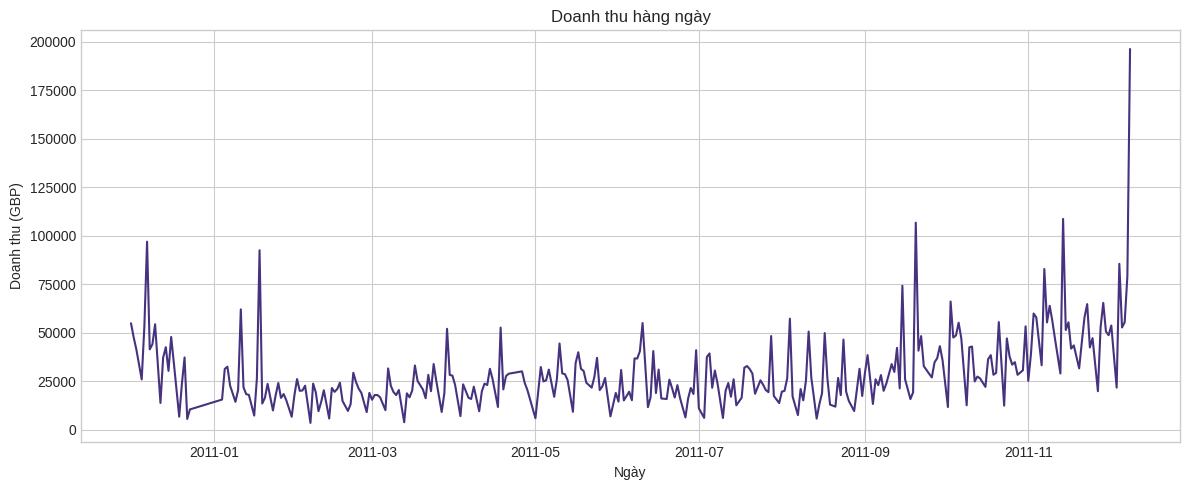

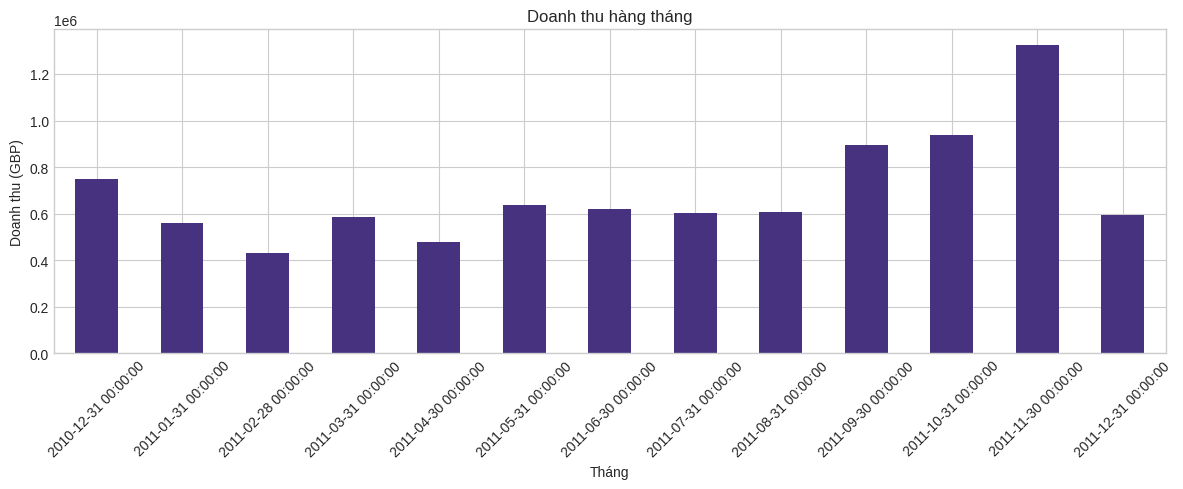

In [19]:
# Phân tích doanh thu theo thời gian
visualizer.plot_revenue_over_time(df_uk)

### Mẫu thời gian mua hàng

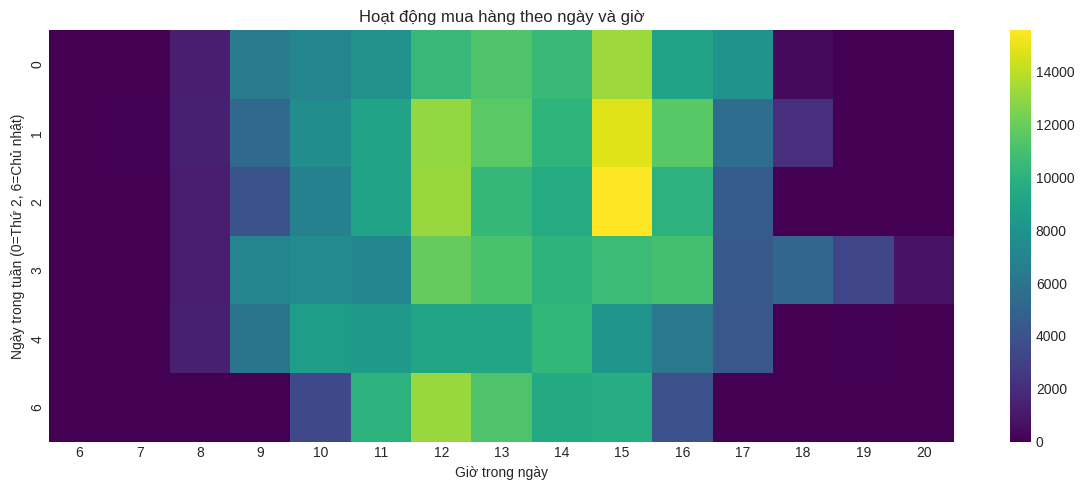

In [20]:
# Phân tích mẫu thời gian mua hàng
visualizer.plot_time_patterns(df_uk)

## Phân tích sản phẩm

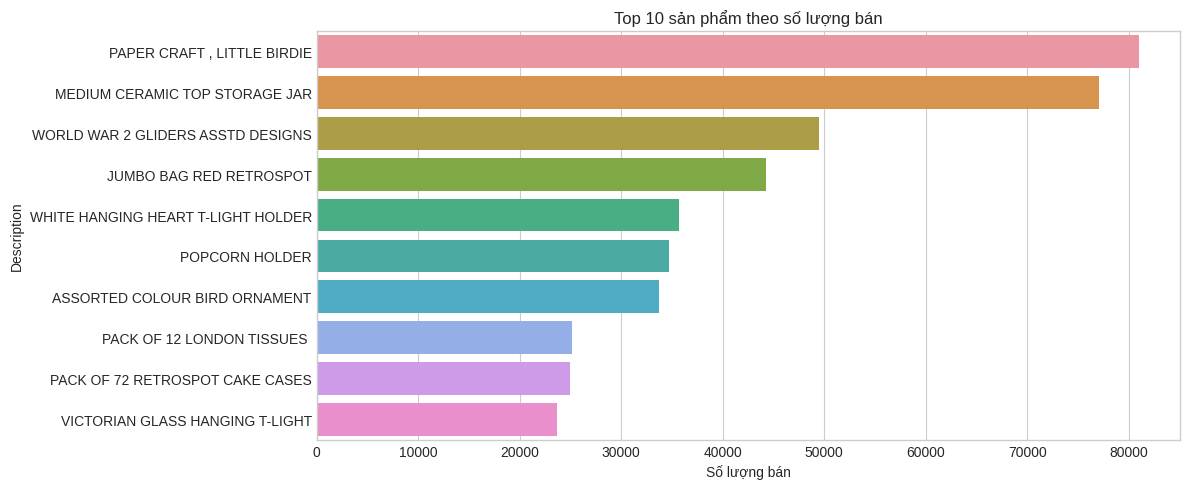

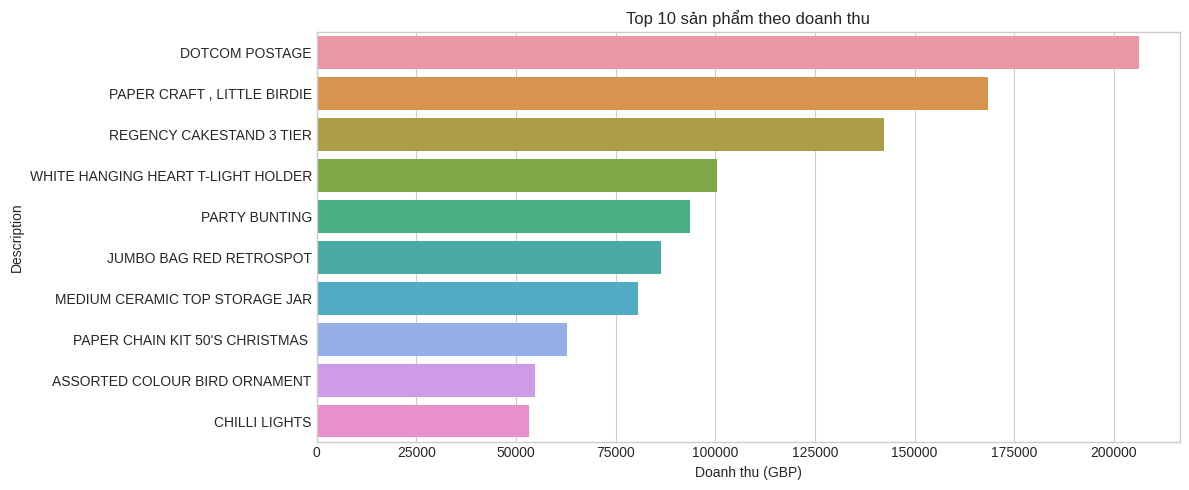

In [21]:
# Phân tích sản phẩm top
visualizer.plot_product_analysis(df_uk)

## Phân tích khách hàng

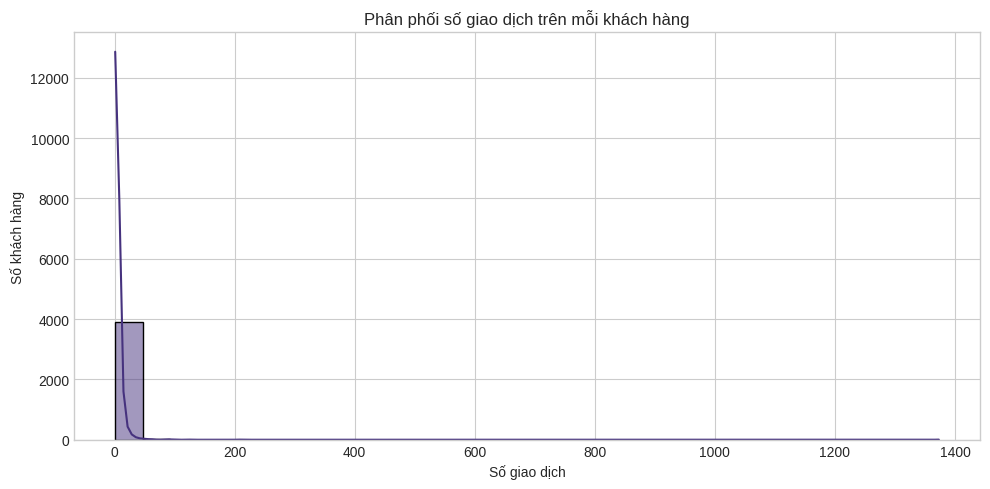

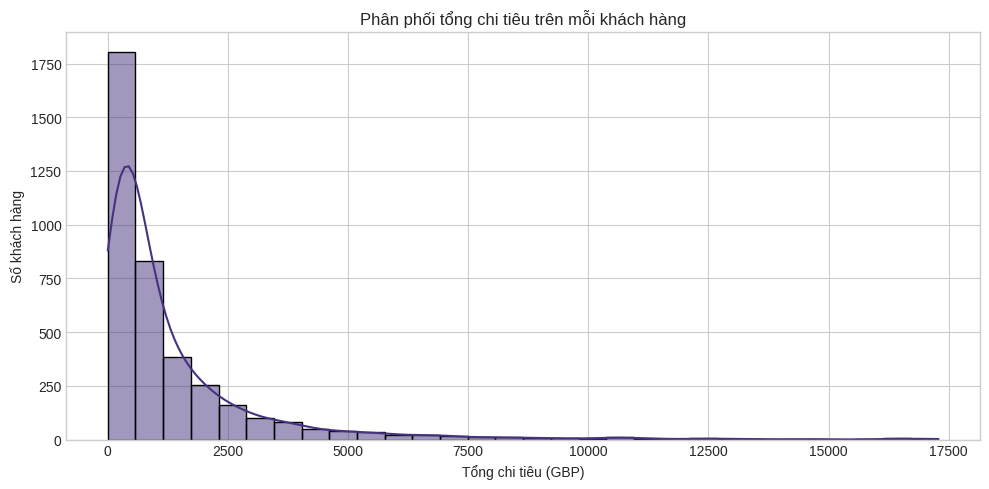

In [22]:
# Phân tích phân phối hành vi khách hàng
visualizer.plot_customer_distribution(df_uk)

In [23]:
# Phân tích chi tiêu khách hàng
spend_per_customer = df_uk.groupby("CustomerID")["TotalPrice"].sum()
transactions_per_customer = df_uk.groupby("CustomerID")["InvoiceNo"].nunique()

print("Phân tích hành vi khách hàng:")
print(f"- Chi tiêu trung bình: £{spend_per_customer.mean():.2f}")
print(f"- Chi tiêu median: £{spend_per_customer.median():.2f}")
print(f"- Giao dịch trung bình: {transactions_per_customer.mean():.1f} lần")

spend_per_customer.describe()

Phân tích hành vi khách hàng:
- Chi tiêu trung bình: £2301.77
- Chi tiêu median: £652.74
- Giao dịch trung bình: 4.6 lần


count    3.921000e+03
mean     2.301765e+03
std      2.839137e+04
min      3.750000e+00
25%      3.003600e+02
50%      6.527400e+02
75%      1.578670e+03
max      1.716831e+06
Name: TotalPrice, dtype: float64

## Chuẩn bị phân tích RFM

RFM viết tắt của:
- **R**ecency (Gần đây): Khách hàng mua hàng lần cuối cách đây bao lâu?
- **F**requency (Tần suất): Họ mua hàng thường xuyên như thế nào?
- **M**onetary (Tiền tệ): Họ chi tiêu bao nhiều tiền?

In [24]:
# Tính toán các chỉ số RFM (Recency, Frequency, Monetary)
rfm_data = cleaner.calculate_rfm()

print("Phân tích RFM:")
print(f"- Trung bình Recency: {rfm_data['Recency'].mean():.0f} ngày")
print(f"- Trung bình Frequency: {rfm_data['Frequency'].mean():.1f} giao dịch")
print(f"- Trung bình Monetary: £{rfm_data['Monetary'].mean():.2f}")

rfm_data.head(10)

Phân tích RFM:
- Trung bình Recency: 92 ngày
- Trung bình Frequency: 4.6 giao dịch
- Trung bình Monetary: £2301.77


,Recency,Frequency,Monetary
CustomerID,,,
000nan,1,1373,1716830.53
012346,326,1,77183.60
012747,2,11,4196.01
012748,1,209,33719.73
012749,4,5,4090.88
012820,3,4,942.34
012821,214,1,92.72
012822,71,2,948.88
012823,75,5,1759.50


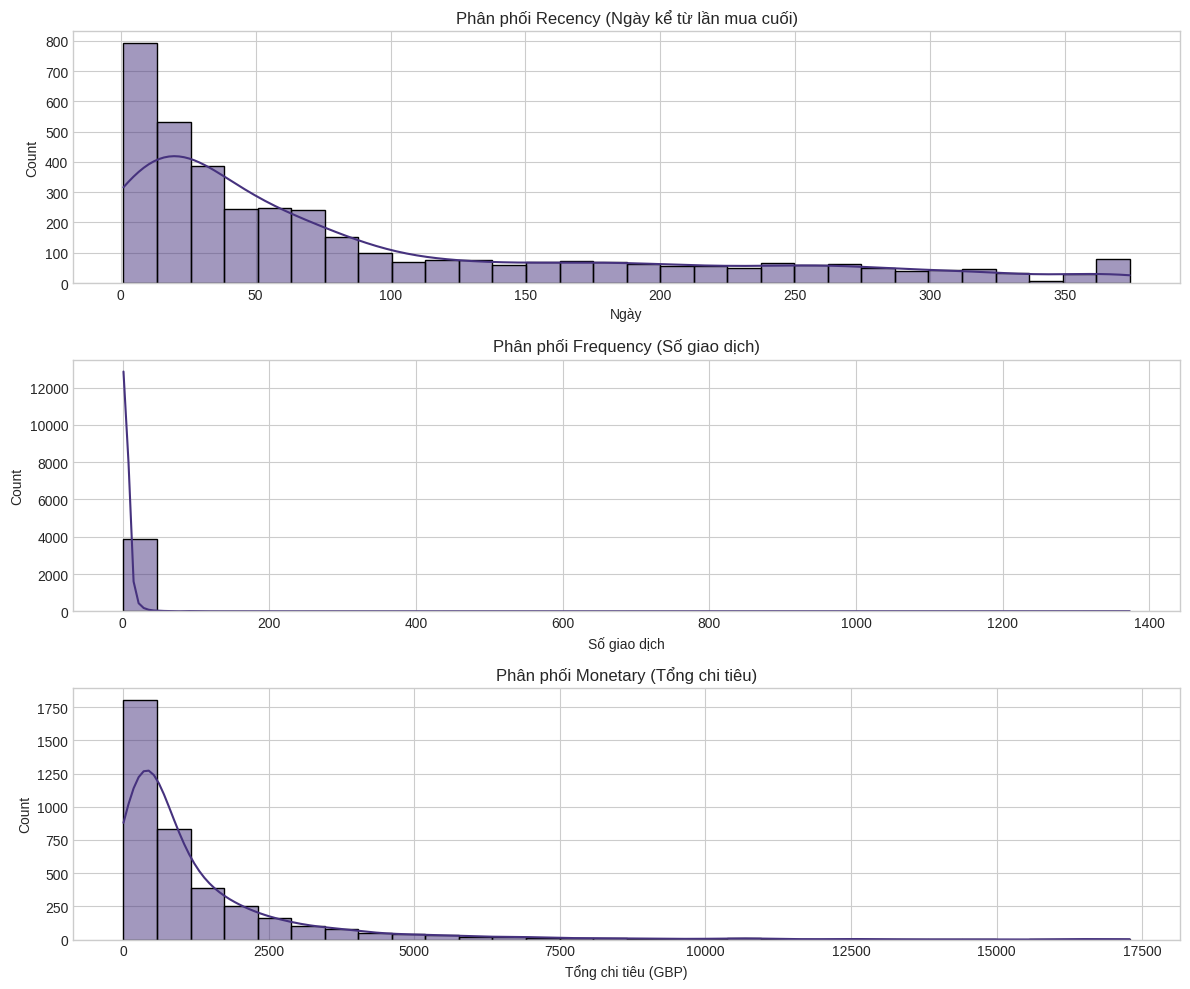

In [25]:
# Trực quan hóa phân phối RFM
visualizer.plot_rfm_analysis(rfm_data)

## Lưu dữ liệu đã làm sạch

In [26]:
# Lưu dữ liệu đã làm sạch
cleaner.save_cleaned_data()

print("Dữ liệu đã được lưu thành công:")
print("- File: cleaned_uk_data.csv")
print(f"- Kích thước: {df_uk.shape[0]:,} dòng")
print("- Sẵn sàng cho bước feature engineering")

Đã lưu dữ liệu đã làm sạch: ../data/processed/cleaned_uk_data.csv
Dữ liệu đã được lưu thành công:
- File: cleaned_uk_data.csv
- Kích thước: 485,123 dòng
- Sẵn sàng cho bước feature engineering


## Tóm tắt

Trong notebook này, chúng ta đã:

1. **Tải dữ liệu** từ tập dữ liệu Online Retail
2. **Làm sạch dữ liệu** bằng cách:
   - Thêm cột TotalPrice
   - Loại bỏ hóa đơn bị hủy
   - Lọc chỉ khách hàng UK
   - Loại bỏ bản ghi thiếu CustomerID
   - Loại bỏ quantity/price không hợp lệ
3. **Khám phá dữ liệu** thông qua:
   - Mẫu doanh thu theo thời gian
   - Mẫu thời gian mua hàng (ngày/giờ)
   - Sản phẩm top theo số lượng và doanh thu
   - Phân tích hành vi khách hàng
   - Phân tích RFM (Recency, Frequency, Monetary)
4. **Lưu dữ liệu đã làm sạch** cho việc tạo features

### Phát hiện chính:
- Tập dữ liệu bao gồm từ tháng 12/2010 đến tháng 12/2011
- Sau khi làm sạch, chúng ta có **354,321** giao dịch từ **3,920** khách hàng UK duy nhất
- Doanh thu cho thấy xu hướng tăng theo thời gian
- Hầu hết việc mua hàng diễn ra trong giờ làm việc (các ngày trong tuần)
- Chi tiêu và tần suất giao dịch của khách hàng rất đa dạng

<br/><div class="cpr" style="text-align:center">
Copyright © Nguyen Thai Ha. All Rights Reserved.
</div>　